In [78]:
import sys
sys.path.append("..")
import numpy as np
bzi = 31
pwx = 3
pw = (pwx, 1)
twist_angle = np.deg2rad(0)
wl = 1.01
cell_size = 1
theta = 0

In [79]:
from khepri.beams import gen_bzi_grid
import matplotlib.pyplot as plt
from khepri import Expansion
from khepri.tools import reciproc

kbz = gen_bzi_grid((bzi, bzi), a=cell_size, reciproc=None).reshape(2, -1).T
if twist_angle != 0:
    fig, (ax, ax2) = plt.subplots(2, 1, figsize=(2,2))
    ax.scatter(*kbz.T)
    e1, e2 = Expansion(pw), Expansion(pw)
    e2.rotate(twist_angle)
    etw = e1 + e2
    kx, ky, _ = etw.k_vectors((0,0), wl, 1)
    k0 = 2 * np.pi / wl
    ax.scatter(k0 * kx.flatten(), k0*ky.flatten())
    v1 = 5
    v2 = 7
    ax.scatter(k0 * kx[v1], k0*ky[v1])
    ax.scatter(k0 * kx[v2], k0*ky[v2])
    basis = np.array([[k0 * kx[v1], k0*ky[v1]], [k0 * kx[v2], k0*ky[v2]]])
    kbz = gen_bzi_grid((bzi, bzi), a=cell_size, reciproc=basis).reshape(2, -1).T
    ax2.scatter(*kbz.T)
    ax2.scatter(k0 * kx.flatten(), k0*ky.flatten())
    a1, a2 = reciproc(basis[0], basis[1])

else:
    a1, a2 = [1,0], [0,1]


(1, 1, 3, 3) (341, 341, 3, 1)


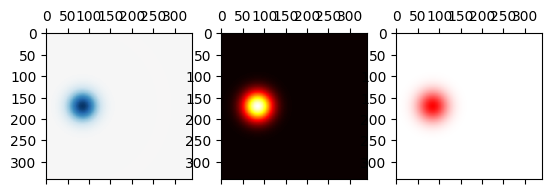

In [80]:
from khepri.beams import _paraxial_gaussian_field_fn, shifted_rotated_fields
NS = int(11 * cell_size)
x = np.linspace(0, cell_size*bzi, NS*bzi, endpoint=True)
y = np.linspace(0, cell_size*bzi, NS*bzi, endpoint=True)
Xh, Yh = np.meshgrid(x, y, indexing="ij")
X = a1[0] * Xh + a2[0] * Yh
Y = a1[1] * Xh + a2[1] * Yh

Z = np.zeros_like(X)
source_real = shifted_rotated_fields(_paraxial_gaussian_field_fn, X, Y, Z, wl, np.max(x)/2, np.max(y)/4, -2, theta, 0, 0, beam_waist=3.1)[..., 0]
fig, (ax1,ax2,ax3) = plt.subplots(1,3)
ax1.matshow(source_real[0, 0, ...].real, cmap="RdBu", vmin=-1, vmax=1)
ax2.matshow(np.abs(source_real[0, 0, ...]), cmap="hot", vmin=0, vmax=1)
ax3.matshow(np.imag(source_real[0, 0, ...]), cmap="hsv", vmin=0, vmax=1, alpha=np.abs(source_real[0, 0, ...]))
source_real = np.swapaxes(source_real, 0, 2)
source_real = np.swapaxes(source_real, 1, 3)

In [81]:
from khepri import Expansion, Crystal, Layer, Drawing
def get_crystal(kp):
    pattern = Drawing((128,128), 4)
    pattern.rectangle((0,0), (0.2,1), 1)
    if twist_angle != 0:
        e1, e2 = Expansion(pw), Expansion(pw)
        e2.rotate(twist_angle)
        etw = e1 + e2
        cl = Crystal.from_expansion(etw)
        #cl.a = cell_size
        cl.add_layer("Sref",  Layer.half_infinite(e1, "reflexion", 1), True)
        #cl.add_layer("S1",    Layer.uniform(e1, 1.0,  0.5), True)
        #cl.add_layer("S1",    Layer.uniform(e1, 1.0,  0.2), True)
        cl.add_layer("S1",    Layer.pixmap(e1, pattern.canvas(),  0.4), True)
        cl.add_layer("S2",    Layer.pixmap(e2, pattern.canvas(),  0.4), True)
        cl.add_layer("Strans",Layer.half_infinite(e2, "transmission", 1), True)
    else:
        cl = Crystal(pw, epse=1)
        #cl.add_layer_uniform("S1", 1, 0.5)
        cl.add_layer_pixmap("S1", pattern.canvas(), 0.4)
        cl.add_layer_pixmap("S2", pattern.canvas(), 0.4)
        #cl.add_layer_uniform("S2", 1, 0.5)
    cl.set_source(wl, np.nan, np.nan, kp=kp)
    cl.set_device(["S1", "S2"], [True, True])
    cl.solve()

    return cl


In [82]:
from tqdm import tqdm
from khepri.beams import amplitudes_from_fields

cell_size = 1
a = 1
x = np.linspace(0, cell_size*bzi, 200)
y = np.linspace(0, cell_size*bzi, 200)
x, y = np.meshgrid(x, y, indexing="ij")
Esum = np.zeros((3, len(x), len(y)), dtype=np.complex128)
for kp in tqdm(kbz):
     cl = get_crystal(kp)
     F = amplitudes_from_fields(source_real, cl.expansion, wl, kp, X, Y, (bzi, bzi), a=a).flatten()
     E, H = cl.fields_coords_xy(x, y, 2, F)
     Esum += E
Esum /= len(kbz)

100%|██████████| 961/961 [03:44<00:00,  4.29it/s]


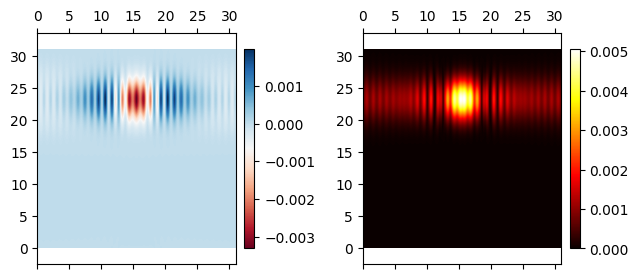

In [83]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(7,3))
extent = [0, np.max(x), 0, np.max(y)]
im1 = ax1.matshow(np.real(Esum[0]).T, cmap="RdBu", extent=extent)
im2 = ax2.matshow(np.abs(Esum[0]).T, cmap="hot", vmin=0, extent=extent)
ax2.axis("equal")
ax1.axis("equal")
plt.colorbar(im1,fraction=0.046, pad=0.04)
plt.colorbar(im2,fraction=0.046, pad=0.04)
plt.subplots_adjust(wspace=0.5)

In [7]:
from tqdm import tqdm
from khepri.beams import amplitudes_from_fields
#source_real = np.swapaxes(source_real, 0, 2)
#source_real = np.swapaxes(source_real, 1, 3)
print(source_real.shape)
cell_size = 1
a = 1
x = np.linspace(0, cell_size*bzi, 100)
y = np.linspace(0, cell_size*bzi, 100)
x, y = np.meshgrid(x, y, indexing="ij")
z = np.linspace(0.001, 6, 100)
Esum = np.zeros((len(z), 3, len(x), len(y)), dtype=np.complex128)
for kp in tqdm(kbz):
     cl = get_crystal(kp)
     F = amplitudes_from_fields(source_real, cl.expansion, wl, kp, X, Y, (bzi, bzi), a=a).flatten()
     E, _ = cl.fields_volume(x, y, z, incident_fields=F)
     Esum += E
Esum /= len(kbz)

(700, 700, 2, 3)


  2%|▏         | 1/49 [00:01<00:48,  1.01s/it]


KeyboardInterrupt: 

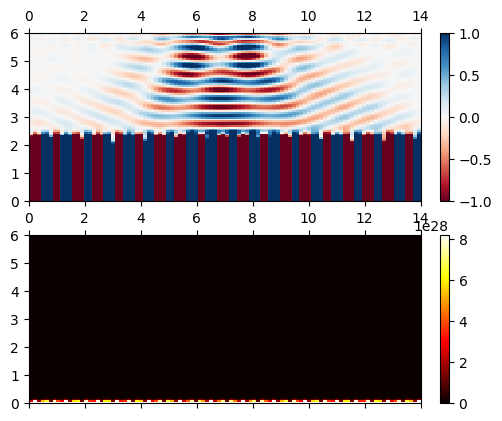

In [9]:
slice = 18
fig, (ax1, ax2) = plt.subplots(2,1)
extent = [0, 2*cell_size*bzi, 0, np.max(z)]
im1 = ax1.matshow(np.real(Esum[:, 0, :, slice]), cmap="RdBu", extent=extent, vmin=-1, vmax=1)
im2 = ax2.matshow(np.abs (Esum[:, 0, :, slice])**2, cmap="hot", vmin=0, extent=extent)
plt.colorbar(im1,fraction=0.046, pad=0.04)
plt.colorbar(im2,fraction=0.046, pad=0.04)